In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Open PGD datasets

In [2]:
ds_list = [
    xr.open_dataset(
        "../simulations/clim/BE40a_l_noTEB/BE40a_l_noTEB_PGD.fa.nc", engine="netcdf4", chunks="auto"
    ).assign_coords({"type": "noTEB"}),
    xr.open_dataset(
        "../simulations/clim/BE40a_l/BE40a_l_PGD.fa.nc", engine="netcdf4", chunks="auto"
    ).assign_coords({"type": "original"}),
    xr.open_dataset(
        "../simulations/clim/BE40a_l_no_urban/BE40a_l_no_urban_PGD.fa.nc", engine="netcdf4", chunks="auto"
    ).assign_coords({"type": "no_urban"}),
]

ds = xr.concat(ds_list, dim="type")
ds

<xarray.Dataset> Size: 625MB
Dimensions:           (type: 3, y: 421, x: 421, nv: 4)
Coordinates:
  * x                 (x) float64 3kB -8.4e+05 -8.36e+05 ... 8.36e+05 8.4e+05
  * y                 (y) float64 3kB 5.572e+06 5.576e+06 ... 7.252e+06
    lon               (y, x) float64 1MB -6.568 -6.519 -6.471 ... 17.82 17.89
    lat               (y, x) float64 1MB 43.01 43.02 43.02 ... 57.89 57.88 57.88
    crs               int64 8B 0
    lat_bounds        (y, x, nv) float64 6MB 43.01 43.02 43.03 ... 57.88 57.88
    lon_bounds        (y, x, nv) float64 6MB -6.568 -6.544 ... 17.89 17.86
  * type              (type) <U8 96B 'noTEB' 'original' 'no_urban'
Dimensions without coordinates: nv
Data variables: (12/287)
    SFX.AOSIM_______  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.AOSIP_______  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.AOSJM_______  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.AOSJP_______  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.ASPECT______  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.AVG_SLO_____  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    ...                ...
    SFX.SSO_STDEV___  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.SVF_________  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.WDRAIN______  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.XX__________  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.YY__________  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
    SFX.ZS__________  (type, y, x) float32 2MB dask.array<chunksize=(1, 421, 421), meta=np.ndarray>
Attributes:
    creation_date:  2024-11-06T09:36:04Z

## Calculate covers/tiles dataset

In [3]:
ds_filled = ds.fillna(0)
da_list = list()

for cover_number in range(1, 574):
    varname = f"SFX.COVER{cover_number:03d}____"
    if varname in ds_filled:
        da = ds_filled[varname]
        da_list.append(da.rename("COVER").assign_coords({"cover": cover_number}))

da = xr.concat(da_list, dim="cover")
ds_covers = da.to_dataset()
ds_covers

<xarray.Dataset> Size: 473MB
Dimensions:  (x: 421, y: 421, type: 3, cover: 221)
Coordinates:
  * x        (x) float64 3kB -8.4e+05 -8.36e+05 -8.32e+05 ... 8.36e+05 8.4e+05
  * y        (y) float64 3kB 5.572e+06 5.576e+06 ... 7.248e+06 7.252e+06
    lon      (y, x) float64 1MB -6.568 -6.519 -6.471 ... 17.76 17.82 17.89
    lat      (y, x) float64 1MB 43.01 43.02 43.02 43.03 ... 57.89 57.88 57.88
    crs      int64 8B 0
  * type     (type) <U8 96B 'noTEB' 'original' 'no_urban'
  * cover    (cover) int64 2kB 1 2 3 151 155 156 157 ... 568 569 570 571 572 573
Data variables:
    COVER    (cover, type, y, x) float32 470MB dask.array<chunksize=(1, 1, 421, 421), meta=np.ndarray>

In [4]:
ds_filled = ds.fillna(0)
da_list = list()

varname = "SFX.FRAC_SEA____"
da = ds_filled[varname]
da_list.append(da.rename("TILE").assign_coords({"tile": "sea"}))

varname = "SFX.FRAC_WATER__"
da = ds_filled[varname]
da_list.append(da.rename("TILE").assign_coords({"tile": "water"}))

varname = "SFX.FRAC_TOWN___"
da = ds_filled[varname]
da_list.append(da.rename("TILE").assign_coords({"tile": "town"}))

varname = "SFX.FRAC_NATURE_"
da = ds_filled[varname]
da_list.append(da.rename("TILE").assign_coords({"tile": "nature"}))

da = xr.concat(da_list, dim="tile")
ds_tiles = da.to_dataset()
ds_tiles

<xarray.Dataset> Size: 11MB
Dimensions:  (x: 421, y: 421, type: 3, tile: 4)
Coordinates:
  * x        (x) float64 3kB -8.4e+05 -8.36e+05 -8.32e+05 ... 8.36e+05 8.4e+05
  * y        (y) float64 3kB 5.572e+06 5.576e+06 ... 7.248e+06 7.252e+06
    lon      (y, x) float64 1MB -6.568 -6.519 -6.471 ... 17.76 17.82 17.89
    lat      (y, x) float64 1MB 43.01 43.02 43.02 43.03 ... 57.89 57.88 57.88
    crs      int64 8B 0
  * type     (type) <U8 96B 'noTEB' 'original' 'no_urban'
  * tile     (tile) <U6 96B 'sea' 'water' 'town' 'nature'
Data variables:
    TILE     (tile, type, y, x) float32 9MB dask.array<chunksize=(1, 1, 421, 421), meta=np.ndarray>

## Plot sum of covers and tiles

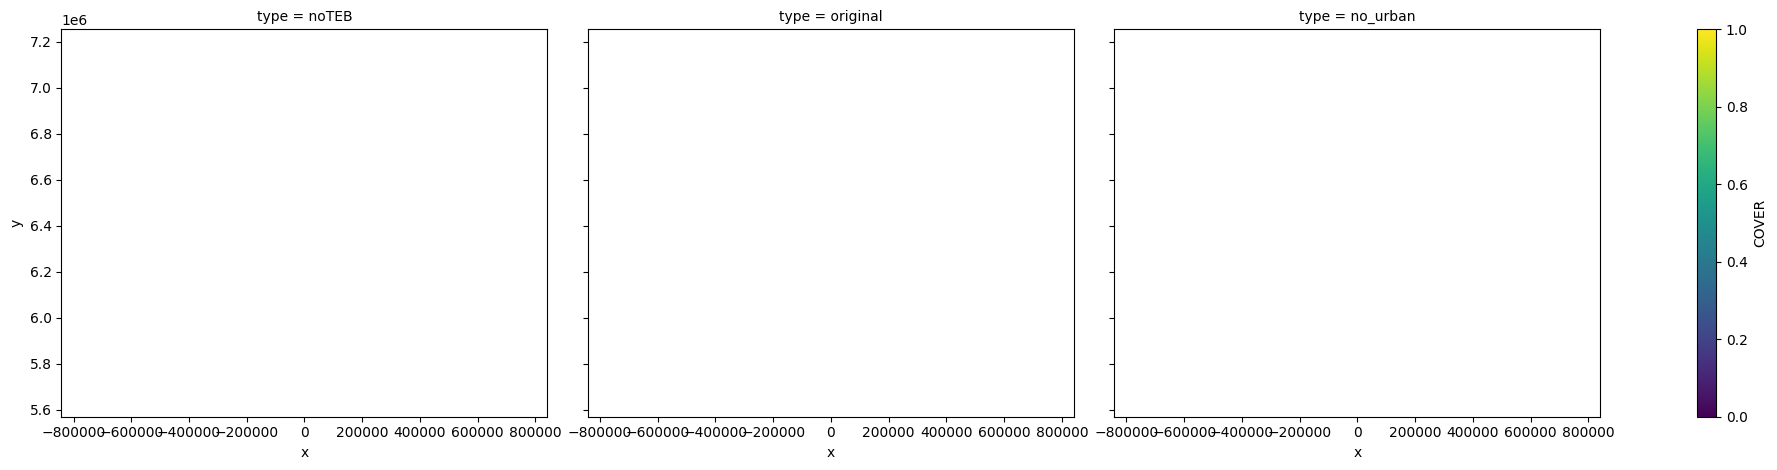

array([nan, nan, nan], dtype=float32)

In [5]:
ds_covers_sum = ds_covers["COVER"].sum(dim="cover")
ds_covers_sum_masked = ds_covers_sum.where(ds_covers_sum < 1.0 - 1e-6)
ds_covers_sum_masked.plot(col="type", aspect=4 / 3, size=4.8, vmin=0, vmax=1)
plt.show()
ds_covers_sum_masked.min(dim=["x", "y"]).values

We have plotted the sum of all covers for the three types of PGDs. We only plotted the points were the sum was smaller than $1 - 10^{-6}$ . The minimum value of the sum is 0.16667 . 

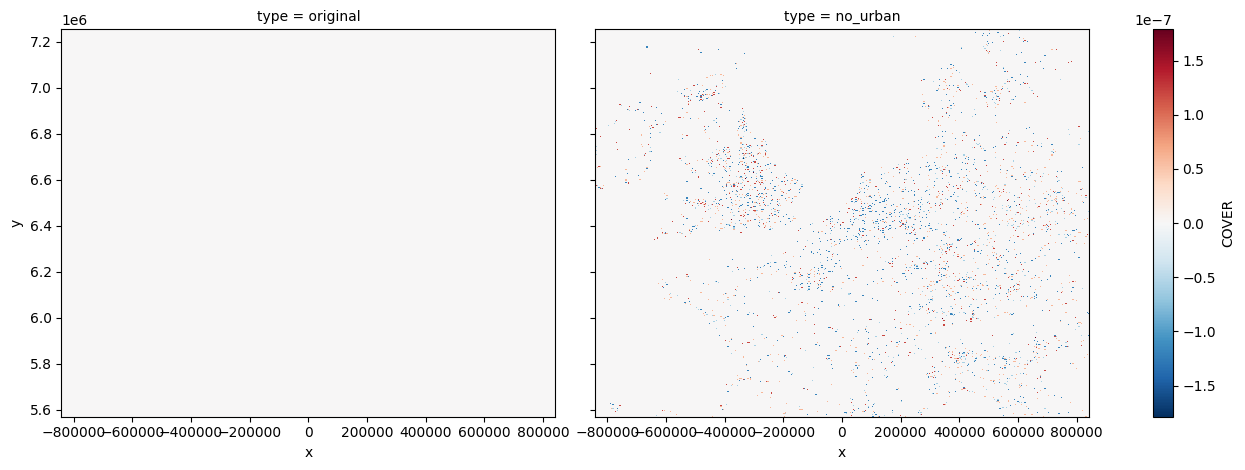

In [6]:
ds_covers_sum.diff(dim="type").plot(col="type", aspect=4 / 3, size=4.8)
plt.show()

Next, we plotted all points were the sum of all covers differs between the types. The left plot compares original and noTEB, the right plot compares original and no_urban. The differences are contained to about $10^{-7}$. So, the sum of all covers are virtually identical across the types. The fact that the sum is smaller than 1 in some points is unrelated to the LPS tool.

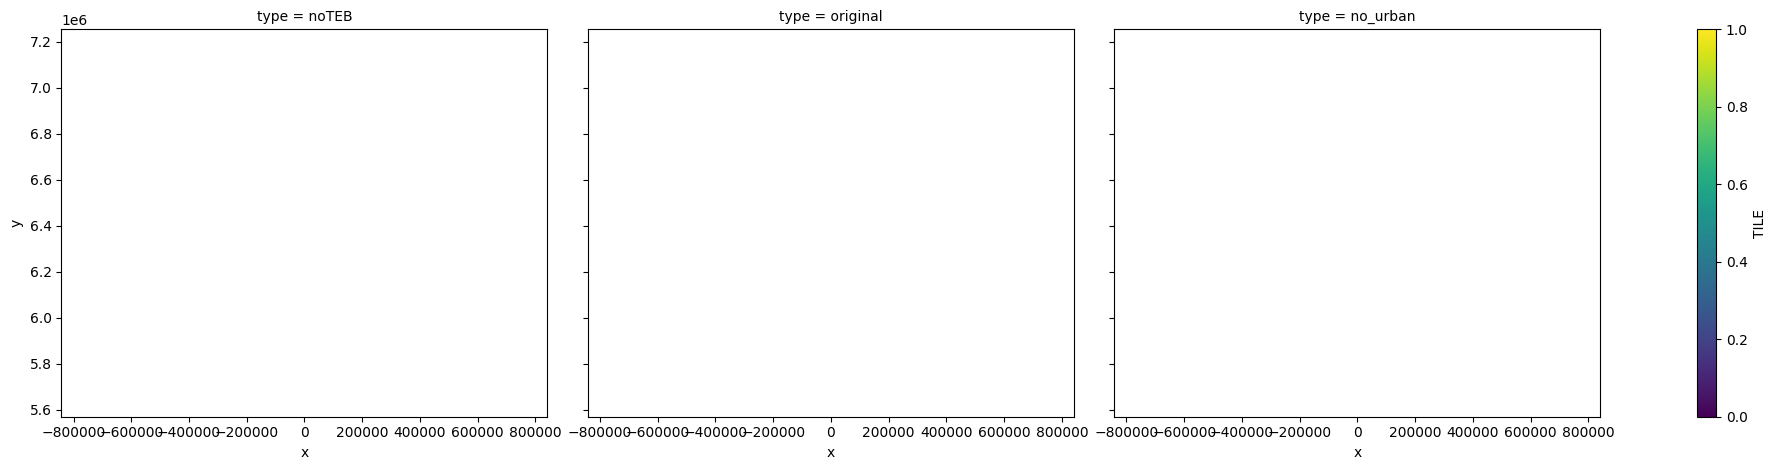

array([nan, nan, nan], dtype=float32)

In [7]:
ds_tiles_sum = ds_tiles["TILE"].sum(dim="tile")
ds_tiles_sum_masked = ds_tiles_sum.where(ds_tiles_sum < 1.0 - 1e-6)
ds_tiles_sum_masked.plot(col="type", aspect=4 / 3, size=4.8, vmin=0, vmax=1)
plt.show()
ds_tiles_sum_masked.min(dim=["x", "y"]).values

The sum of the tile fraction on the other hand is nicely one everywhere and for every type.

# Investigate town fraction
## Plot town fraction

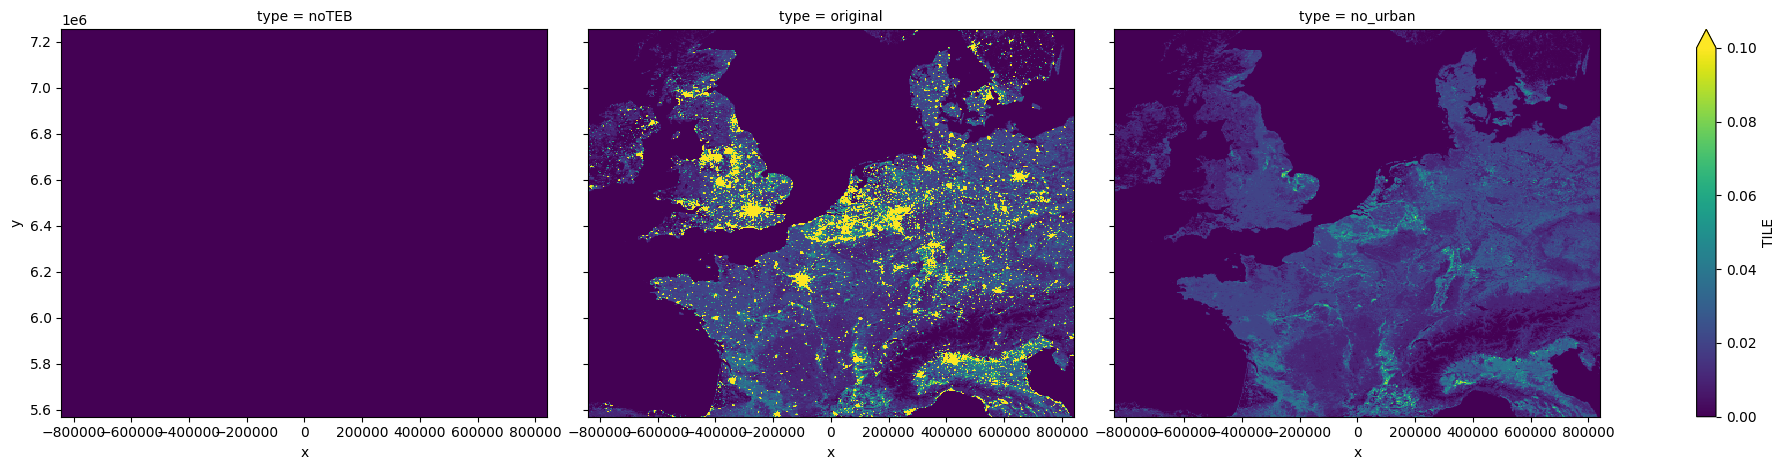

In [8]:
ds_tiles["TILE"].sel(tile="town").plot(
    col="type", aspect=4 / 3, size=4.8, vmin=0, vmax=0.1
)
plt.show()

In what points is the town fraction higher than zero in no_urban but different than in original?

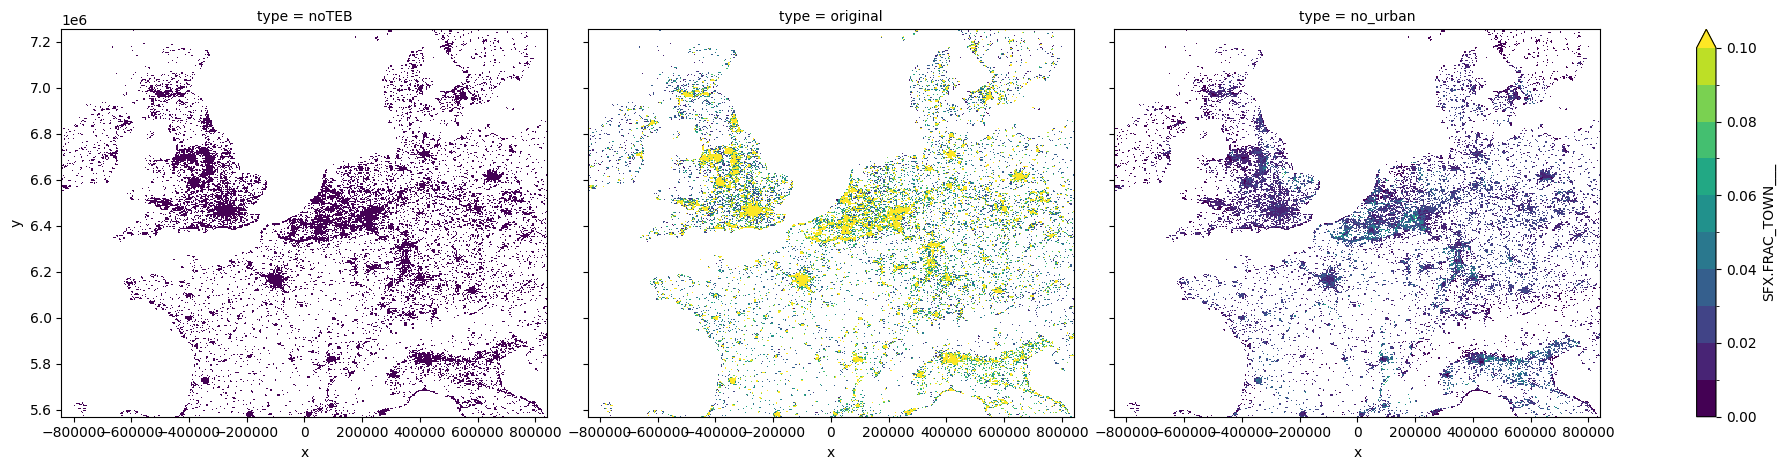

In [9]:
town_frac = ds["SFX.FRAC_TOWN___"]
mask1 = (town_frac.sel(type="original") - town_frac.sel(type="no_urban")) > 0
mask2 = town_frac.sel(type="no_urban") > 0
mask = mask1 & mask2
town_frac_masked = town_frac.where(mask)

town_frac_masked.plot(
    col="type", levels=np.arange(0, 0.11, 0.01), extend="max", aspect=4 / 3, size=4.8
)
plt.show()

We now calculate the difference in covers between the original and no_urban PGDs. The plotted difference is calculated as original value - no_urban. So negative values indicate covers that are reduced (removed) from the original file.

In [10]:
ds_filled = ds.fillna(0)
ds_diff = (
    ds_filled.sel(type=["original", "no_urban"])
    .diff(dim="type")
    .assign_coords(type=["difference"])
    .isel(type=0)
)

for cover_number in range(1, 574):
    varname = f"SFX.COVER{cover_number:03d}____"
    if varname in ds_diff:
        max_diff = np.max(np.abs(ds_diff[varname])).values
        if max_diff > 1e-9:
            # fig, ax = plt.subplots()
            # ds_diff[varname].plot(levels=[-1.001, -0.5, -0.2, -0.1, -0.05, 0.05, 0.1, 0.2, 0.5, 1.001])
            min_diff = ds_diff[varname].min().values
            max_diff = ds_diff[varname].max().values
            # ax.set_title(f"COVER {cover_number:03d}\nmin = {min_diff:.2f} ; max = {max_diff:.2f}")
            print(
                f"COVER {cover_number:03d}\nmin = {min_diff:.2f} ; max = {max_diff:.2f}"
            )

COVER 151
min = -0.80 ; max = 0.00
COVER 155
min = -0.66 ; max = 0.00
COVER 156
min = -0.13 ; max = 0.00
COVER 157
min = -0.50 ; max = 0.00
COVER 158
min = -0.88 ; max = 0.00
COVER 159
min = -0.97 ; max = 0.00
COVER 160
min = -0.35 ; max = 0.00
COVER 161
min = -0.63 ; max = 0.00
COVER 312
min = 0.00 ; max = 0.87
COVER 317
min = 0.00 ; max = 0.29
COVER 319
min = 0.00 ; max = 1.00
COVER 320
min = 0.00 ; max = 1.00
COVER 322
min = 0.00 ; max = 1.00
COVER 326
min = 0.00 ; max = 1.00
COVER 329
min = 0.00 ; max = 0.75
COVER 352
min = 0.00 ; max = 0.85
COVER 355
min = 0.00 ; max = 0.16
COVER 362
min = 0.00 ; max = 1.00
COVER 363
min = 0.00 ; max = 1.00
COVER 364
min = 0.00 ; max = 1.00
COVER 392
min = 0.00 ; max = 1.00
COVER 454
min = 0.00 ; max = 1.00
COVER 455
min = 0.00 ; max = 1.00
COVER 457
min = 0.00 ; max = 0.96
COVER 466
min = 0.00 ; max = 1.00
COVER 481
min = 0.00 ; max = 0.16
COVER 484
min = 0.00 ; max = 1.00
COVER 486
min = 0.00 ; max = 1.00
COVER 487
min = 0.00 ; max = 1.00
COVER 

# FIND COVERS THAT ARE SUPPOSEDLY URBAN BUT NOT REALLY
First we plot the town fraction for all the points which have the same town fraction between original and no_urban.

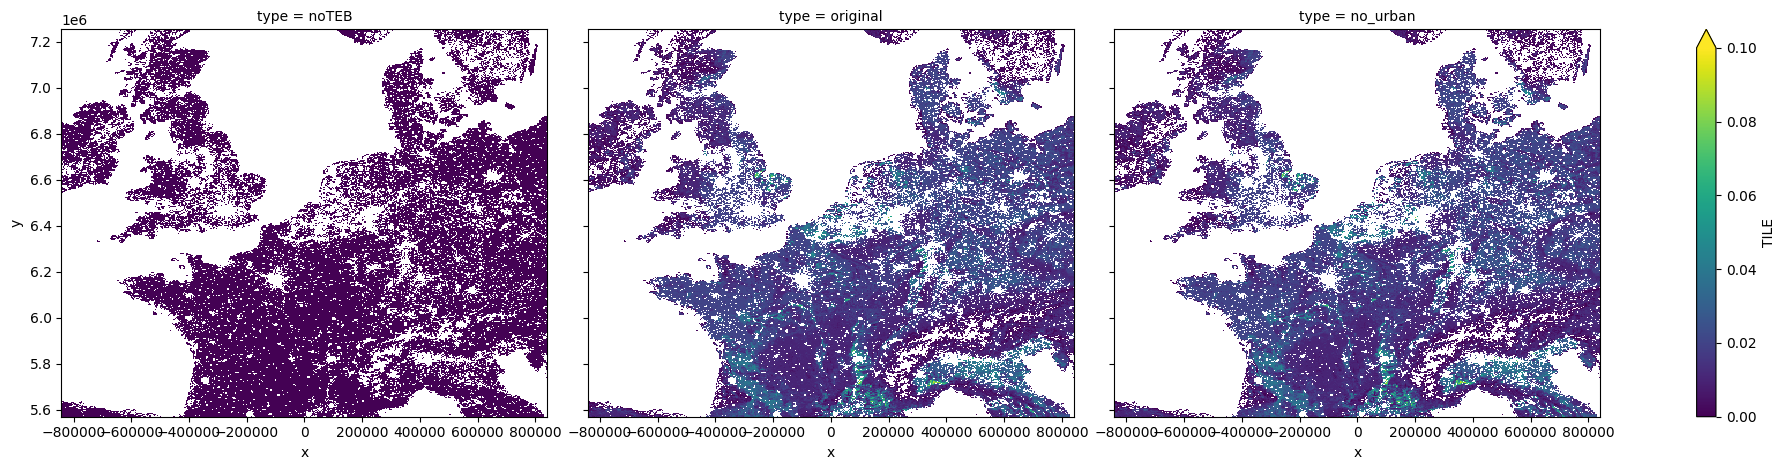

In [11]:
town_frac = ds_tiles["TILE"].sel(tile="town")
town_frac_original = town_frac.sel(type="original")
town_frac_original_points = town_frac_original.stack(points=["x", "y"])

# Find points where town fraction is higher than zero, but equal between original and no_urban
town_frac_original = town_frac.sel(type="original")
town_frac_no_urban = town_frac.sel(type="no_urban")

mask1 = np.abs(town_frac_original - town_frac_no_urban) < 1e-6
mask2 = town_frac_original > 1e-6
mask = mask1 & mask2

town_frac_masked = town_frac.where(mask)
town_frac_masked.plot(
    col="type", aspect=4 / 3, size=4.8, vmin=0, vmax=0.1, extend="max"
)

## Calculate town coefficients for each cover
Next, we calculate the town coefficient for each cover with the following algorithm. First we look for all points where a cover is 100 %. With this value we can easily determine the cover-specific town tile fraction. Next, we loop over all points with only one cover with an unknown coefficient. Based on previously calculated coefficients, we can calculate the coefficient for this cover too. We continue until everything is calculated, or nothing can be calculated anymore.

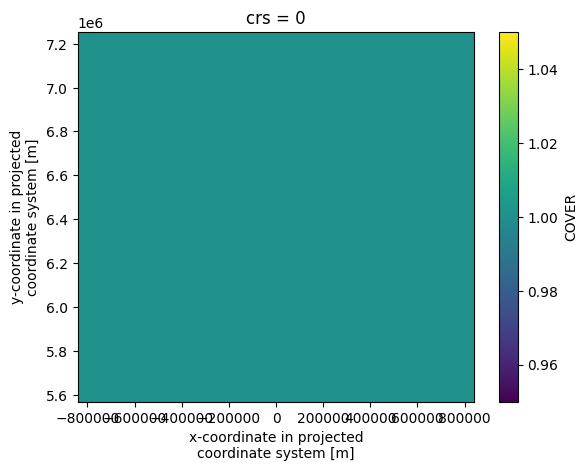

In [12]:
ds_covers_sum = ds_covers["COVER"].sum(dim="cover")
mask = (ds_covers_sum > 1.0 - 1e-6).all(dim="type")
mask.plot()

ds_covers_original = ds_covers["COVER"].sel(type="original")
ds_covers_masked_original = ds_covers_original.where(mask)

town_frac_original = town_frac.sel(type="original")
town_frac_masked_original = town_frac_original.where(mask)

town_frac_masked_original_points = town_frac_masked_original.stack(points=["x", "y"])
town_frac_original_points = town_frac_original.stack(points=["x", "y"])

ds_covers_masked_original_points = ds_covers_masked_original.stack(points=["x", "y"])
ds_covers_original_points = ds_covers_original.stack(points=["x", "y"])

In [13]:
cond = (ds_covers_masked_original_points == 1).load()

ds_covers_masked_original_points_dropped = ds_covers_masked_original_points.dropna(
    dim="points"
).load()
town_frac_masked_original_points_dropped = town_frac_masked_original_points.dropna(
    dim="points"
).load()

covers_to_check = cond.any(dim="points")
da_coeff = xr.DataArray(
    data=np.ones(len(ds_covers_masked_original_points_dropped.cover)) * -1,
    dims="cover",
    coords={"cover": ds_covers_masked_original_points_dropped.cover},
)

for check_idx in range(len(covers_to_check)):
    check = covers_to_check[check_idx]
    cover = check.cover
    if check.values:
        X = ds_covers_masked_original_points_dropped.sel(cover=cover)
        y = town_frac_masked_original_points_dropped
        da_coeff[check_idx] = y.values[np.argmax(X.values)]
        print(f"Cover {cover:03d}")

Cover 001
Cover 002
Cover 301
Cover 314
Cover 317
Cover 318
Cover 319
Cover 320
Cover 321
Cover 322
Cover 324
Cover 325
Cover 326
Cover 330
Cover 331
Cover 332
Cover 333
Cover 351
Cover 352
Cover 353
Cover 355
Cover 360
Cover 361
Cover 362
Cover 363
Cover 364
Cover 392
Cover 393
Cover 443
Cover 444
Cover 445
Cover 446
Cover 450
Cover 451
Cover 452
Cover 453
Cover 454
Cover 455
Cover 456
Cover 457
Cover 459
Cover 465
Cover 466
Cover 469
Cover 470
Cover 474
Cover 481
Cover 482
Cover 484
Cover 485
Cover 486
Cover 487
Cover 488
Cover 489
Cover 491
Cover 492
Cover 493
Cover 494
Cover 521
Cover 538
Cover 546
Cover 549
Cover 552
Cover 553
Cover 561
Cover 562
Cover 565


In [14]:
covers_points = ds_covers_masked_original_points.dropna(dim="points").load()
town_frac_points = town_frac_masked_original_points.dropna(dim="points").load()

nonzero_covers_points = covers_points > 0

specified_covers = (
    da_coeff["cover"].where(da_coeff > -0.01).dropna(dim="cover").astype(int).values
)
specified_covers_mask = da_coeff > -0.01
non_specified_covers = (
    da_coeff["cover"].where(da_coeff < -0.01).dropna(dim="cover").astype(int).values
)
print(f"Number of unspecified covers = {len(non_specified_covers)}")

points_to_look_into = covers_points.points.where(
    (nonzero_covers_points & ~specified_covers_mask).sum(dim="cover") == 1
).dropna(dim="points")
print(f"Number of points to look into = {len(points_to_look_into)}")

while len(non_specified_covers) and len(points_to_look_into):
    for point in points_to_look_into[:1]:
        covers_point = covers_points.sel(points=point)
        nonzero_covers_point = nonzero_covers_points.sel(points=point)
        print(
            f"Cover fractions in point : {covers_point.where(nonzero_covers_point).dropna(dim='cover').values}"
        )
        print(
            f"Covers in point : {covers_point.where(nonzero_covers_point).dropna(dim='cover').cover.values}"
        )

        new_cover = int(
            covers_points.cover.where(
                nonzero_covers_point & ~specified_covers_mask
            ).dropna("cover")
        )
        print(f"New cover = {new_cover}")
        town_frac_sum = (da_coeff.where(da_coeff > -0.01) * covers_point).sum().values
        town_frac_point = town_frac_points.sel(points=point).values
        cover_frac = covers_point.sel(cover=new_cover).values
        new_coeff = (town_frac_point - town_frac_sum) / cover_frac
        if new_coeff < 0.001:
            new_coeff = 0
        print(f"New coefficient = {new_coeff}")
        da_coeff.loc[dict(cover=new_cover)] = new_coeff
        print("---------------------------------------------")

    specified_covers = (
        da_coeff["cover"].where(da_coeff > -0.01).dropna(dim="cover").astype(int).values
    )
    specified_covers_mask = da_coeff > -0.01
    non_specified_covers = (
        da_coeff["cover"].where(da_coeff < -0.01).dropna(dim="cover").astype(int).values
    )

    print(f"Number of unspecified covers = {len(non_specified_covers)}")
    points_to_look_into = covers_points.points.where(
        (nonzero_covers_points & ~specified_covers_mask).sum(dim="cover") == 1
    ).dropna(dim="points")
    print(f"Number of points to look into = {len(points_to_look_into)}")

Number of unspecified covers = 154
Number of points to look into = 39311
Cover fractions in point : [0.08333334 0.41666666 0.08333334 0.41666666]
Covers in point : [326 329 333 454]
New cover = 329
New coefficient = 0
---------------------------------------------
Number of unspecified covers = 153
Number of points to look into = 36041
Cover fractions in point : [0.07692308 0.03846154 0.3846154  0.03846154 0.07692308 0.11538462
 0.26923078]
Covers in point : [325 326 329 335 361 362 454]
New cover = 335
New coefficient = 0.009999982342125024
---------------------------------------------
Number of unspecified covers = 152
Number of points to look into = 35798
Cover fractions in point : [0.08 0.12 0.52 0.28]
Covers in point : [331 332 333 341]
New cover = 341
New coefficient = 0
---------------------------------------------
Number of unspecified covers = 151
Number of points to look into = 35759
Cover fractions in point : [0.9        0.03333334 0.06666667]
Covers in point : [  1 363 460]


We round the found coefficients to 2 digits (as ECOCLIMAP does). First, we check the difference with the rounded values and the raw values:

(array([  1.,   2.,   7., 200.,   3.,   3.,   3.,   1.,   0.,   1.]),
 array([-9.13636005e-07, -6.44366239e-07, -3.75096473e-07, -1.05826707e-07,
         1.63443059e-07,  4.32712825e-07,  7.01982591e-07,  9.71252357e-07,
         1.24052212e-06,  1.50979189e-06,  1.77906166e-06]),
 <BarContainer object of 10 artists>)

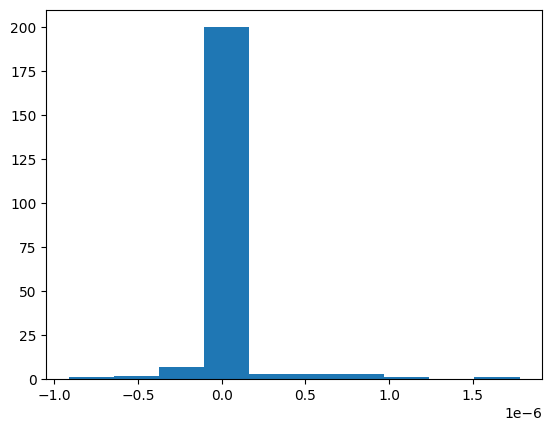

In [15]:
(da_coeff.round(2) - da_coeff).plot.hist()

We plot the coefficients

In [16]:
da_coeff.round(2).cover.values

array([  1,   2,   3, 151, 155, 156, 157, 158, 159, 160, 161, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 340, 341, 342,
       344, 345, 346, 347, 348, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 369, 370, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 385, 386,
       387, 389, 390, 391, 392, 393, 398, 400, 401, 402, 403, 404, 405,
       411, 413, 415, 425, 426, 427, 428, 429, 430, 431, 439, 440, 441,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 506, 508, 509, 510, 511, 512, 514, 51

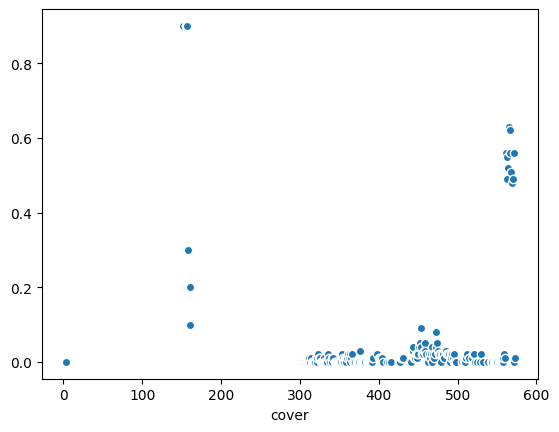

In [17]:
da_coeff.round(2).plot.scatter(x="cover")

We compute the town fraction ourselves and compare with town fraction from PGD.

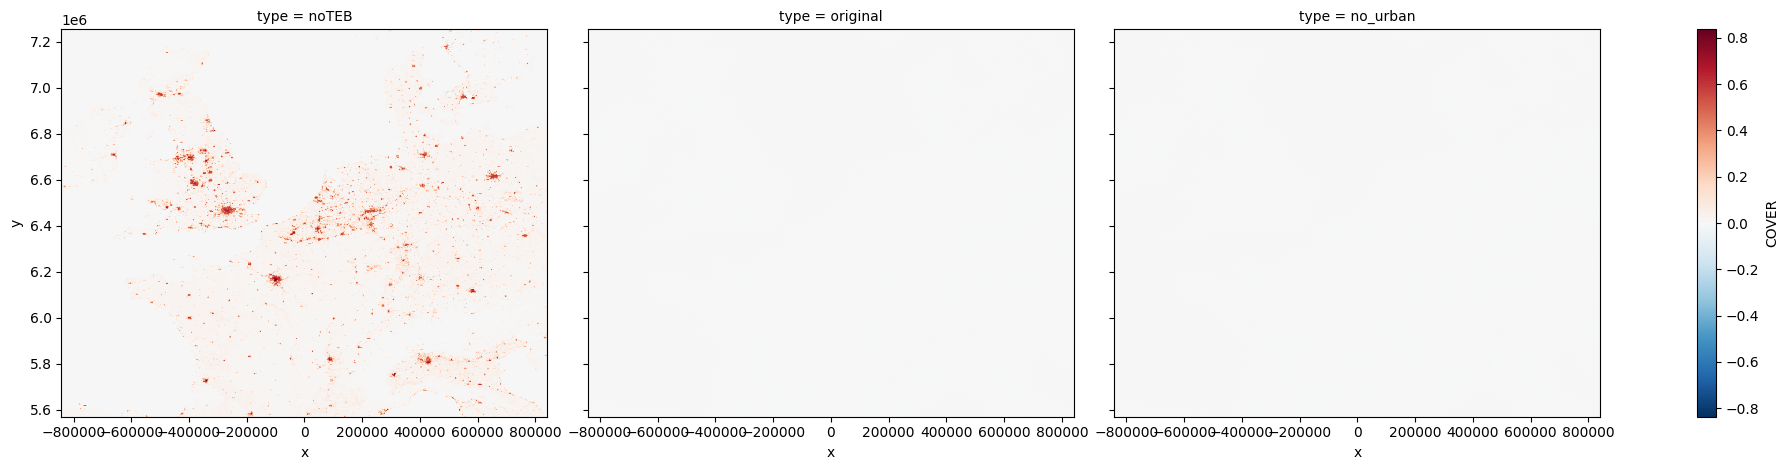

In [18]:
town_frac_myself = da_coeff.round(3) * ds_covers
(town_frac_myself.sum("cover") - town_frac).COVER.plot(
    col="type", aspect=4 / 3, size=4.8
)

## Linear regression

In [19]:
town_frac = ds_tiles["TILE"].sel(tile="town")
town_frac_original = town_frac.sel(type="original")
town_frac_original_points = town_frac_original.stack(points=["x", "y"])

# Find points where town fraction is higher than zero, but equal between original and no_urban
town_frac_original = town_frac.sel(type="original")
town_frac_no_urban = town_frac.sel(type="no_urban")

mask1 = np.abs(town_frac_original - town_frac_no_urban) < 1e-6
mask2 = town_frac_original > 1e-6
mask = mask1 & mask2
mask = 1

ds_covers_original = ds_covers["COVER"].sel(type="original")
ds_covers_masked_original = ds_covers_original.where(mask)

town_frac_original = town_frac.sel(type="original")
town_frac_masked_original = town_frac_original.where(mask)

town_frac_masked_original_points = town_frac_masked_original.stack(points=["x", "y"])
town_frac_original_points = town_frac_original.stack(points=["x", "y"])

ds_covers_masked_original_points = ds_covers_masked_original.stack(points=["x", "y"])
ds_covers_original_points = ds_covers_original.stack(points=["x", "y"])

In [20]:
y.shape

(177241,)

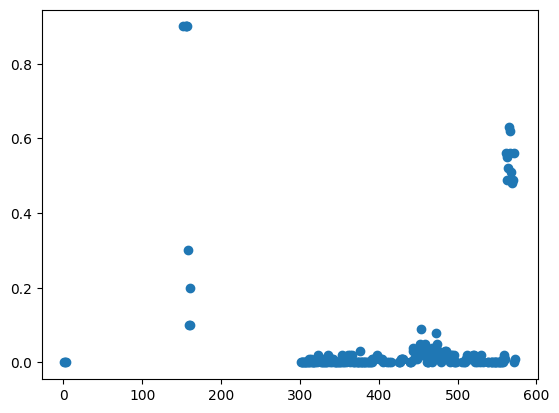

In [21]:
X = ds_covers_masked_original_points.dropna(dim="points").astype(float).values.T
y = town_frac_masked_original_points.dropna(dim="points").astype(float).values

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

coefficients = model.coef_
plt.scatter(x=ds_covers.cover.values, y=coefficients)

In [22]:
(coefficients.round(3) == da_coeff.round(3)).all().values

array(True)

Linear regression values and algorithm values are the same!

# Differences between noTEB and original

In [23]:
ds_covers_filled = ds_covers.fillna(0)
ds_diff = (
    ds_covers_filled.sel(type=["original", "noTEB"])
    .diff(dim="type")
    .assign_coords(type=["difference"])
    .isel(type=0)
    .COVER
)

In [24]:
counter = 0
for cover in ds_diff.cover:
    max_diff = np.max(np.abs(ds_diff.sel(cover=cover))).values
    if max_diff > 1e-9:
        # fig, ax = plt.subplots()
        # ds_diff[varname].plot(levels=[-1.001, -0.5, -0.2, -0.1, -0.05, 0.05, 0.1, 0.2, 0.5, 1.001])
        min_diff = ds_diff[cover].min().values
        max_diff = ds_diff[cover].max().values
        # ax.set_title(f"COVER {cover_number:03d}\nmin = {min_diff:.2f} ; max = {max_diff:.2f}")
        print(f"COVER {cover_number:03d}\nmin = {min_diff:.2f} ; max = {max_diff:.2f}")
    print(max_diff)
    counter += 1
print(counter)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
221


Covers between original and noTEB are identical!

# Save to file

In [25]:
df = (da_coeff.round(2)).rename("Town_coefficients").to_dataframe()
df.to_csv("ECOCLIMAP_cover_town_coefficients.csv")